# Imports & Settings

In [16]:
conda activate off_ai_emlyon


Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np 
import re
import os
import time 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

#robotoff
from robotoff.products import ProductDataset
from robotoff.taxonomy import get_taxonomy

from IPython.lib.deepreload import reload as dreload
from pandas import json_normalize

#custom module
from off_emlyon_module.datanavig import off_columns_dict as cols
from off_emlyon_module.functions import *

#Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
sns.set()

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1 - Preprocessing PNNS Groups & Predictions

In [19]:
%%time
df_raw = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\machine learning\Open Food Facts\data\merged_predictions_off_v2.csv', low_memory=False)

Wall time: 20.1 s


In [20]:
%%time
df_tax = pd.read_json(r'C:\Users\Antoine\Coding Bootcamp\machine learning\Open Food Facts\data\taxonomy_pnns.json')
df_tax.head()

Wall time: 25.9 ms


all_taxonomy_possibilities  \
0                               {'en:appetizers': 0}   
1  {'en:artificially-sweetened-beverages': 2, 'en...   
2  {'en:biscuits': 10, 'en:biscuits-and-cakes': 2...   
3  {'en:bagel-breads': 7, 'en:baguette-made-with-...   
4  {'en:breakfast-cereals': 1, 'en:breakfast-cere...   

                               pnns                  taxonomy_suggestion  
0                        appetizers                        en:appetizers  
1  artificially sweetened beverages  en:artificially-sweetened-beverages  
2                biscuits and cakes                en:biscuits-and-cakes  
3                             bread                            en:breads  
4                 breakfast cereals                 en:breakfast-cereals

In [22]:
df_tax.all_taxonomy_possibilities[1]

{'en:artificially-sweetened-beverages': 2,
 'en:beverages': 23,
 'en:sweetened-beverages': 14,
 'en:teas': 28}

In [21]:
type(df_tax.all_taxonomy_possibilities[1])

dict

In [23]:
#Keep only filled categories tags
df = df_raw.dropna(subset=['categories_tags'])

In [24]:
#Apply only on rows with 'unknown' or NaN pnns
def find_pnns(row, df_taxonomy):
    output = np.nan
    tags_list = row.split(',')
    tax_list = get_taxonomy_info(tags_list[0])
    if not isinstance(tax_list, float):
        tax_list = tax_list + tags_list
        tax_list = [tax.strip(' ').strip('') for tax in tax_list]
        tax_list = list(set(tax_list))
        for suggestion, pnns in zip(df_taxonomy.taxonomy_suggestion, df_taxonomy.pnns):
            if suggestion in tax_list:
                output = pnns
                break
            else:
                continue
        if isinstance(output, float):
            for possibilities, pnns in zip(df_taxonomy.all_taxonomy_possibilities, df_tax.pnns):
                for possibility in possibilities.keys():
                    if possibility in tax_list:
                        output = pnns
                        break
                    else :
                        continue
    return output

In [ ]:
#Find pnns from robotoff value predicition
#Find pnns where pnns_groups_2 is unknown

In [25]:
%%time
df['robotoff_pnns'] =  df['robotoff_value_tag'].apply(lambda row: find_pnns(row=row, df_taxonomy=df_tax))

Wall time: 19.6 s


In [26]:
%%time
df['pnns_groups_2'].loc[df['pnns_groups_2'] == 'unknown'] = df['categories_tags'].apply(lambda row: find_pnns(row=row, df_taxonomy=df_tax))

Wall time: 11.1 s


In [39]:
#Clean strings
df['pnns_groups_2'] = df['pnns_groups_2'].str.lower()
df['robotoff_pnns'] = df['robotoff_pnns'].str.lower()

In [43]:
df["pnns_groups_2"] = df["pnns_groups_2"].apply(lambda x: x.replace("-", " ") if not isinstance(x, float) else x)

In [47]:
#Looking pnns groups info for preds & trues
print(f"Trues pnns count : {df['pnns_groups_2'].count()}")
print(f"Preds pnns count : {df['pnns_groups_2'].count()}")
print(f"True pnns unique : {len(set(df['pnns_groups_2']))}")
print(f"Preds pnns unique : {len(set(df['robotoff_pnns']))}")

Trues pnns count : 80994
Preds pnns count : 80994
True pnns unique : 41
Preds pnns unique : 39


In [45]:
df[['pnns_groups_2', 'robotoff_pnns']].isnull().sum()

pnns_groups_2     8011
robotoff_pnns    28208
dtype: int64

In [46]:
len(df)

89005

In [44]:
df['pnns_groups_2'].value_counts()

sweets                              11105
cheese                               6479
biscuits and cakes                   5453
dressings and sauces                 4734
cereals                              4084
vegetables                           3907
processed meat                       3690
one dish meals                       3459
sweetened beverages                  3364
milk and yogurt                      2991
meat                                 2772
fish and seafood                     2579
artificially sweetened beverages     2531
fats                                 2142
fruits                               2081
bread                                2000
dairy desserts                       1938
unsweetened beverages                1559
breakfast cereals                    1398
chocolate products                   1263
salty and fatty products             1037
appetizers                           1011
waters and flavored waters            951
nuts                              

In [35]:
df['robotoff_pnns'].value_counts()

cheese                              5162
fruits                              5043
vegetables                          3638
meat                                3576
nuts                                3041
dressings and sauces                2805
sweets                              2519
bread                               2476
cereals                             2353
chocolate products                  2315
fruit juices                        2194
sweetened beverages                 2096
biscuits and cakes                  2030
appetizers                          1703
one dish meals                      1479
breakfast cereals                   1468
milk and yogurt                     1330
unsweetened beverages               1317
waters and flavored waters          1298
fish and seafood                    1177
ice cream                           1110
teas and herbal teas and coffees    1037
legumes                              999
dairy desserts                       992
plant based milk

In [63]:
pnns_to_drop = set(df.pnns_groups_2) - set(df.robotoff_pnns)
df = df[~df.pnns_groups_2.isin(pnns_to_drop)]
df = df.dropna(subset=['pnns_groups_2', 'robotoff_pnns'])
df.shape

(55226, 197)

In [202]:
#Adding a col with values equal to 1 if pred is valid, else 0
df['pred_is_true'] = df.apply(lambda x: 1 if x['pnns_groups_2'] == x['robotoff_pnns'] else 0, axis=1)
#Assert accuracy and mean for pred_is_true are equal
df.pred_is_true.mean() == metrics.accuracy_score(y_test, y_preds)

True

In [365]:
df.to_csv(r'C:\Users\Antoine\Coding Bootcamp\machine learning\Open Food Facts\data\processed_predictions.csv')

# Part 2 - Models Evaluation

## Uncomment if part 1 not runned
df = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\machine learning\Open Food Facts\data\processed_predictions.csv', low_memory=False)
df.shape

In [364]:
#Relevant imports for model evaluation
from sklearn import metrics
from off_emlyon_module.model_evaluation import *
from off_emlyon_module.model_evaluation import classifier_metrics
from off_emlyon_module.model_evaluation import get_classification_report
from off_emlyon_module.model_evaluation import plot_confusion_matrix
pd.set_option("display.max_columns", 50)

In [74]:
#Defining y variables for classification metrics
y_preds = df.robotoff_pnns
y_test = df.pnns_groups_2
#Check if len and len(set) are equal
len(y_test) - len(y_preds), len(set(y_preds)) - len(set(y_test)) 

(0, 0)

In [169]:
#Add a new key in cols_dict with relevant columns for model evaluation
from off_emlyon_module.datanavig import off_columns_dict as cols
robodict = {'models':['robotoff_value_tag', 'robotoff_data.model', 'robotoff_data.confidence', 'pred_is_true', 'robotoff_pnns', 'pnns_groups_2']}
cols.update(robodict)

In [121]:
#Setting a palette for col 'pred_is_true'
hue_palette = {0:'darkred', 1:'darkgreen'}

### Global metrics

In [369]:
classifier_metrics(y_test=y_test, y_preds=y_preds, average='weighted', model='Global')

Global Classification Metrics :
-------------------
Accuracy : 48.76%
Recall : 48.76%
Precision : 60.41%
F1-score : 49.06%




### Multiclass report

In [294]:
report = get_classification_report(y_test, y_preds, model='global', sortby='f1-score')
report.T

cheese    eggs  dressings and sauces    bread  \
global_precision     0.86    0.77                  0.85     0.67   
global_recall        0.93    0.88                  0.66     0.85   
global_f1-score      0.90    0.82                  0.75     0.75   
global_support    4461.00  239.00               3263.00  1710.00   

                  fish and seafood  pizza pies and quiche     meat  \
global_precision              0.75                   0.60     0.53   
global_recall                 0.73                   0.76     0.78   
global_f1-score               0.74                   0.67     0.63   
global_support             1063.00                 608.00  2208.00   

                  processed meat  milk and yogurt  sweetened beverages  \
global_precision            0.80             0.75                 0.64   
global_recall               0.49             0.45                 0.43   
global_f1-score             0.61             0.56                 0.51   
global_support           1348.00          2058.00              2960.00   

                  biscuits and cakes  vegetables  weighted avg  accuracy  \
global_precision                0.76        0.46          0.60      0.49   
global_recall                   0.37        0.53          0.49      0.49   
global_f1-score                 0.50        0.49          0.49      0.49   
global_support               3727.00     2641.00      55226.00      0.49   

                  breakfast cereals  waters and flavored waters  \
global_precision               0.46                        0.38   
global_recall                  0.51                        0.57   
global_f1-score                0.49                        0.45   
global_support              1273.00                      789.00   

                  chocolate products  dried fruits   fruits  macro avg  \
global_precision                0.31          0.37     0.29       0.43   
global_recall                   0.70          0.50     0.76       0.49   
global_f1-score                 0.43          0.43     0.42       0.42   
global_support                984.00        589.00  1784.00   55226.00   

                  fruit nectars  ice cream  fruit juices   sweets  \
global_precision           0.31       0.27          0.27     0.81   
global_recall              0.58       0.73          0.70     0.24   
global_f1-score            0.40       0.39          0.39     0.37   
global_support            69.00     391.00        775.00  7844.00   

                  teas and herbal teas and coffees  sandwiches  \
global_precision                              0.30        0.34   
global_recall                                 0.46        0.39   
global_f1-score                               0.36        0.36   
global_support                              591.00      215.00   

                  one dish meals  artificially sweetened beverages  \
global_precision            0.53                              0.87   
global_recall               0.27                              0.22   
global_f1-score             0.36                              0.35   
global_support           2522.00                           2310.00   

                  dairy desserts    nuts    fats  cereals  legumes  \
global_precision            0.47    0.21    0.45     0.30     0.19   
global_recall               0.26    0.75    0.25     0.31     0.38   
global_f1-score             0.33    0.33    0.32     0.30     0.25   
global_support           1641.00  785.00  458.00  2163.00   442.00   

                  appetizers  potatoes   soups  plant based milk substitutes  \
global_precision        0.17      0.14    0.18                          0.08   
global_recall           0.41      0.74    0.31                          0.22   
global_f1-score         0.24      0.24    0.23                          0.12   
global_support        630.00    144.00  251.00                        328.00   

                  unsweetened beverages  offals  pastries  \
global_precision           

In [307]:
plt.figure(figsize=(8,10))
sns.pointplot(y=report.index, x=report['global_f1-score'], palette='terrain')
plt.title('F1-score by category', fontsize=16)

Text(0.5,1,'F1-score by category')

In [282]:
#Testing custom Facet Grids
df_test = df.loc[(df['pnns_groups_2'] == 'sweets') | (df['pnns_groups_2'] == 'legumes')]
labels = df_test.pnns_groups_2.unique()
g = sns.FacetGrid(df_test, col="pnns_groups_2", hue="pred_is_true", palette=hue_palette,  xlim=(0, 1), height=4)
g.map(sns.kdeplot, "robotoff_data.confidence", fill=True, alpha=.4, common_norm=True)
for ax, label in zip(g.axes.flat, labels):
   ax.set_title(f'{label} - f1-score : {report["global_f1-score"][label]}')

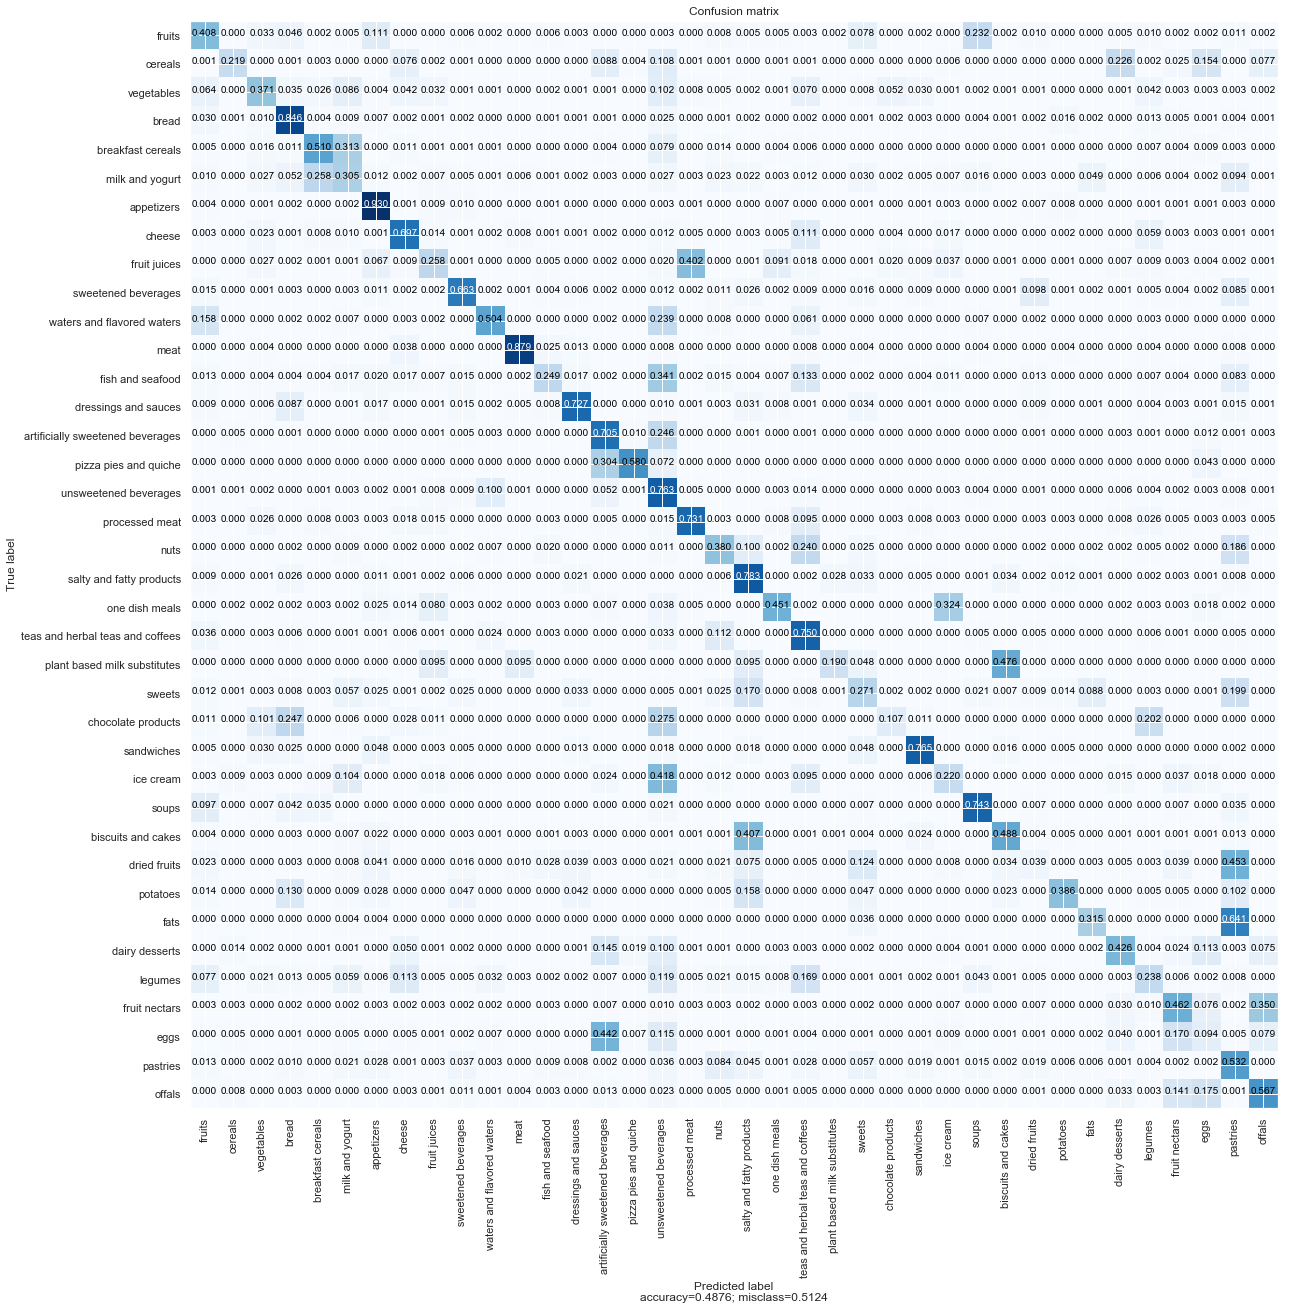

In [323]:
plot_confusion_matrix(cm=metrics.confusion_matrix(y_test, y_preds), target_names=y_preds.unique(), figsize=(20,20), cmap='Blues')

In [172]:
df[cols['models']].loc[df['pred_is_true'] == 0].head(30)

robotoff_value_tag robotoff_data.model  robotoff_data.confidence  \
11                   en:sodas              neural                  0.577453   
65     en:mixed-cereal-flakes              neural                  0.744332   
73     en:plant-based-pickles              neural                  0.524211   
111                 en:breads              neural                  0.696027   
122                en:mueslis              neural                  0.703540   
136             en:appetizers              neural                  0.500359   
146  en:fruit-based-beverages              neural                  0.888056   
147     en:juices-and-nectars              neural                  0.622157   
227                 en:sauces              neural                  0.851380   
310  en:fruit-based-beverages              neural                  0.612440   
319    en:sweetened-beverages              neural                  0.824009   
386            en:fruit-sodas              neural                  0.591379   
387    en:sweetened-beverages              neural                  0.778342   
394      en:carbonated-drinks              neural                  0.600961   
405                   en:teas              neural                  0.573087   
406    en:tea-based-beverages              neural                  0.785935   
407    en:sweetened-beverages              neural                  0.923379   
408             en:green-teas              neural                  0.738781   
409                   en:teas              neural                  0.573087   
410    en:tea-based-beverages              neural                  0.785935   
414  en:fruit-based-beverages              neural                  0.525468   
415             en:baby-foods              neural                  0.513741   
421        en:culinary-plants              neural                  0.587921   
431        en:low-fat-yogurts              neural                  0.531045   
453                en:bonbons              neural                  0.661702   
455             en:condiments              neural                  0.586499   
480        en:culinary-plants              neural                  0.514777   
482                en:coffees              neural                  0.530147   
483                  en:milks              neural                  0.573516   
494                en:yogurts              neural                  0.688739   

     pred_is_true                     robotoff_pnns  \
11              0                            fruits   
65              0                           cereals   
73              0                        vegetables   
111             0                             bread   
122             0                 breakfast cereals   
136             0                        appetizers   
146             0                      fruit juices   
147             0                      fruit juices   
227             0              dressings and sauces   
310             0                      fruit juices   
319             0               sweetened beverages   
386             0                            fruits   
387             0               sweetened beverages   
394             0             unsweetened beverages   
405             0        waters and flavored waters   
406             0             unsweetened beverages   
407             0               sweetened beverages   
408             0        waters and flavored waters   
409             0        waters and flavored waters   
410             0             unsweetened beverages   
414             0                      fruit juices   
415             0                           cereals   
421             0             pizza pies and quiche   
431             0                   milk and yogurt   
453             0                              nuts   
455             0          salty and fatty products   
480             0             pizza pies and quiche   
482             0  te

## Split Neural & Matcher Predictions

In [179]:
df_neural = df[cols['models']].loc[df['robotoff_data.model'] == 'neural']
df_matcher = df[cols['models']].loc[df['robotoff_data.model'] == 'matcher']
df_matcher.shape, df_neural.shape

((8192, 6), (46833, 6))

In [196]:
classifier_metrics(y_test=df_neural.pnns_groups_2, y_preds=df_neural.robotoff_pnns, average='weighted', model='Neural')
classifier_metrics(y_test=df_matcher.pnns_groups_2, y_preds=df_matcher.robotoff_pnns, average='weighted', model='Matcher')

Neural Classification Metrics :
-----
Accuracy : 45.69%
Recall : 45.69%
Precision : 59.11%
F1-score : 46.74%


Matcher Classification Metrics :
-----
Accuracy : 66.05%
Recall : 66.05%
Precision : 71.22%
F1-score : 63.70%




In [306]:
neural_report = get_classification_report(df_neural.pnns_groups_2, df_neural.robotoff_pnns, model='neural')
matcher_report = get_classification_report(df_matcher.pnns_groups_2, df_matcher.robotoff_pnns, model='matcher')
global_report = neural_report.merge(matcher_report, left_index=True, right_index=True)
global_report.T

cheese    eggs    bread  fish and seafood  \
neural_precision      0.83    0.73     0.65              0.74   
neural_recall         0.92    0.84     0.83              0.72   
neural_f1-score       0.88    0.78     0.73              0.73   
neural_support     3227.00  171.00  1349.00            947.00   
matcher_precision     0.96    0.89     0.74              0.90   
matcher_recall        0.94    0.97     0.92              0.82   
matcher_f1-score      0.95    0.93     0.82              0.86   
matcher_support    1211.00   67.00   353.00            111.00   

                   dressings and sauces  pizza pies and quiche  \
neural_precision                   0.84                   0.58   
neural_recall                      0.64                   0.75   
neural_f1-score                    0.73                   0.65   
neural_support                  2837.00                 497.00   
matcher_precision                  0.94                   0.69   
matcher_recall                     0.82                   0.83   
matcher_f1-score                   0.88                   0.76   
matcher_support                  422.00                 110.00   

                   processed meat     meat  milk and yogurt  \
neural_precision             0.80     0.47             0.72   
neural_recall                0.50     0.72             0.46   
neural_f1-score              0.61     0.57             0.56   
neural_support            1160.00  1596.00          1715.00   
matcher_precision            0.82     0.71             0.91   
matcher_recall               0.43     0.95             0.41   
matcher_f1-score             0.56     0.81             0.57   
matcher_support            172.00   597.00           337.00   

                   sweetened beverages  biscuits and cakes  breakfast cereals  \
neural_precision                  0.64                0.75               0.46   
neural_recall                     0.44                0.38               0.53   
neural_f1-score                   0.53                0.51               0.49   
neural_support                 2832.00             3329.00            1183.00   
matcher_precision                 0.00                0.85               0.61   
matcher_recall                    0.00                0.24               0.26   
matcher_f1-score                  0.00                0.38               0.36   
matcher_support                 123.00              389.00              85.00   

                   vegetables  weighted avg  accuracy  \
neural_precision         0.46          0.59      0.46   
neural_recall            0.49          0.46      0.46   
neural_f1-score          0.47          0.47      0.46   
neural_support        2280.00      46833.00      0.46   
matcher_precision        0.45          0.71      0.66   
matcher_recall           0.76          0.66      0.66   
matcher_f1-score         0.57          0.64      0.66   
matcher_support        355.00       8192.00      0.66   

                   waters and flavored waters  macro avg  chocolate products  \
neural_precision                         0.35       0.41                0.26   
neural_recall                            0.53       0.47                0.65   
neural_f1-score                          0.42       0.39                0.37   
neural_support                         713.00   46833.00              770.00   
matcher_precision                        0.60       0.55                0.67   
matcher_recall                           0.95       0.54                0.85   
matcher_f1-score                         0.73       0.51                0.75   
matcher_support                         76.00    8192.00              213.00   

                   one dish meals  artificially sweetened beverages   fruits  \
neural_precision             0.51                              0.88     0.24   
neural_recall                0.28                              0.23     0.69   
neural_f1-score              0.36                              0.3

# Neural network analysis

## Global metrics

In [328]:
#Classification global metrics for neural net
classifier_metrics(y_test=df_neural.pnns_groups_2, y_preds=df_neural.robotoff_pnns, average='macro', model='Neural Net Macro')
classifier_metrics(y_test=df_neural.pnns_groups_2, y_preds=df_neural.robotoff_pnns, average='weighted', model='Neural Net Weighted')

Neural Net Macro Classification Metrics :
-------------------
Accuracy : 45.69%
Recall : 46.51%
Precision : 40.54%
F1-score : 38.69%


Neural Net Weighted Classification Metrics :
-------------------
Accuracy : 45.69%
Recall : 45.69%
Precision : 59.11%
F1-score : 46.74%




In [327]:
#Classification report for neural net
neural_report.T

cheese    eggs    bread  fish and seafood  \
neural_precision     0.83    0.73     0.65              0.74   
neural_recall        0.92    0.84     0.83              0.72   
neural_f1-score      0.88    0.78     0.73              0.73   
neural_support    3227.00  171.00  1349.00            947.00   

                  dressings and sauces  pizza pies and quiche  processed meat  \
neural_precision                  0.84                   0.58            0.80   
neural_recall                     0.64                   0.75            0.50   
neural_f1-score                   0.73                   0.65            0.61   
neural_support                 2837.00                 497.00         1160.00   

                     meat  milk and yogurt  sweetened beverages  \
neural_precision     0.47             0.72                 0.64   
neural_recall        0.72             0.46                 0.44   
neural_f1-score      0.57             0.56                 0.53   
neural_support    1596.00          1715.00              2832.00   

                  biscuits and cakes  breakfast cereals  vegetables  \
neural_precision                0.75               0.46        0.46   
neural_recall                   0.38               0.53        0.49   
neural_f1-score                 0.51               0.49        0.47   
neural_support               3329.00            1183.00     2280.00   

                  weighted avg  accuracy  waters and flavored waters  \
neural_precision          0.59      0.46                        0.35   
neural_recall             0.46      0.46                        0.53   
neural_f1-score           0.47      0.46                        0.42   
neural_support        46833.00      0.46                      713.00   

                  macro avg  chocolate products  one dish meals  \
neural_precision       0.41                0.26            0.51   
neural_recall          0.47                0.65            0.28   
neural_f1-score        0.39                0.37            0.36   
neural_support     46833.00              770.00         2140.00   

                  artificially sweetened beverages   fruits   sweets  \
neural_precision                              0.88     0.24     0.80   
neural_recall                                 0.23     0.69     0.23   
neural_f1-score                               0.36     0.36     0.35   
neural_support                             2181.00  1165.00  7141.00   

                  sandwiches  teas and herbal teas and coffees    fats  \
neural_precision        0.38                              0.26    0.44   
neural_recall           0.32                              0.42    0.25   
neural_f1-score         0.35                              0.32    0.32   
neural_support        183.00                            505.00  408.00   

                  ice cream  fruit juices  dried fruits  cereals  \
neural_precision       0.20          0.20          0.25     0.29   
neural_recall          0.68          0.65          0.38     0.30   
neural_f1-score        0.31          0.30          0.30     0.30   
neural_support       280.00        539.00        393.00  1967.00   

                  dairy desserts   soups  legumes    nuts  appetizers  \
neural_precision            0.43    0.18     0.18    0.14        0.16   
neural_recall               0.22    0.42     0.36    0.69        0.42   
neural_f1-score             0.30    0.25     0.24    0.24        0.24   
neural_support           1498.00  177.00   405.00  484.00      580.00   

                  fruit nectars  potatoes  plant based milk substitutes  \
neural_precision           0.15      0.09                          0.09   
neural_recall              0.34      0.64                          0.23   
neural_f1-score            0.21      0.16                          0.13   
neural_support            35.00     95.00                        292.00   

                  unsweetened beverages  offals  pastries  \
neural_precision           

In [299]:
sns.displot(data=df, x='robotoff_data.confidence', kind='kde', hue='pred_is_true', palette=hue_palette, fill=True, alpha=0.4)
plt.title('Global neural net confidence - kernel density', fontsize=14)

Text(0.5,1,'Global neural net confidence - kernel density')

Text(0.5,1,'Neural network f1-score by pnns')

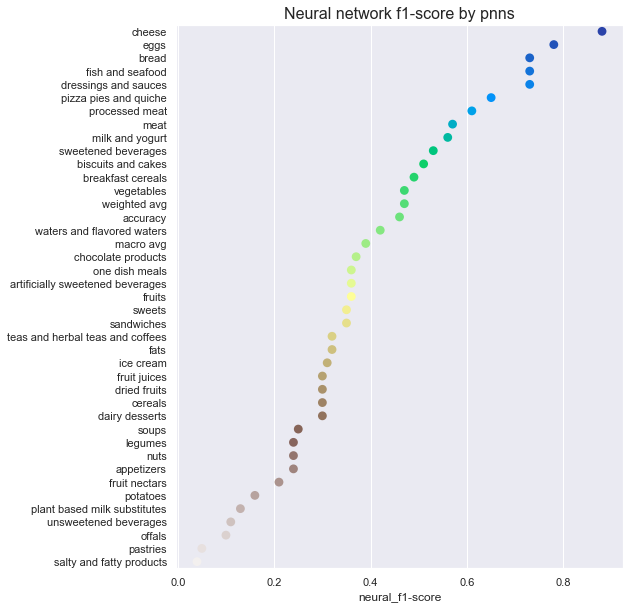

In [329]:
plt.figure(figsize=(8,10))
sns.pointplot(y=neural_report.index, x=neural_report['neural_f1-score'], palette='terrain')
plt.title('Neural network f1-score by pnns', fontsize=16)

In [334]:
neural_recall = neural_report.sort_values(by=['neural_recall'], ascending=False)
plt.figure(figsize=(8,10))
sns.pointplot(y=neural_recall.index, x=neural_recall['neural_recall'], palette='ocean')
plt.title('Neural network recall by pnns', fontsize=16)

Text(0.5,1,'Neural network recall by pnns')

In [336]:
neural_precision = neural_report.sort_values(by=['neural_precision'], ascending=False)
plt.figure(figsize=(8,10))
sns.pointplot(y=neural_precision.index, x=neural_precision['neural_precision'], palette='gist_earth')
plt.title('Neural network precision by pnns', fontsize=16)

Text(0.5,1,'Neural network precision by pnns')

Text(0.5,1,'Neural network support by pnns')

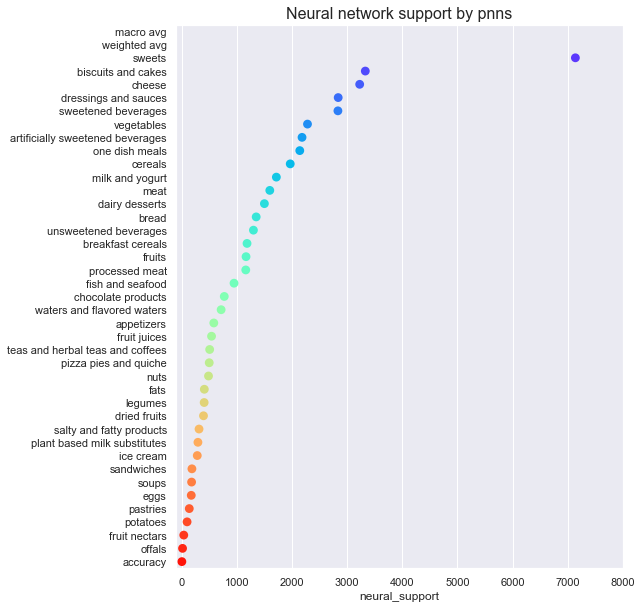

In [347]:
neural_support = neural_report.sort_values(by=['neural_support'], ascending=False)
plt.figure(figsize=(8,10))
sns.pointplot(y=neural_support.index, x=neural_support['neural_support'], palette='rainbow')
plt.xlim(-100,8000)
plt.title('Neural network support by pnns', fontsize=16)

## Neural net confidence KDE by pnns

#### We designed a seaborn FacetGrid and plotted the distribution of the neural net confidence for every pnns group.
    - Used plot function is Kernel Density Estimation
    - Labels used are from 'pnns_groups_2'
    - Model confidence ('robotoff_data.confidence') is in range (0, 1)
    - hue is for 'pred_is_true' : red kdes are the distribution of confidence for all misclassified labels, green for valid ones.
    - F-1 Score is computed for each pnns, using the following formula : 
$$ \text{F}_1\text{-score} = 2. \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [330]:
%%time
labels = df.pnns_groups_2.unique()
g = sns.FacetGrid(df_neural, col="pnns_groups_2", hue="pred_is_true", col_wrap=4, height=5, palette=hue_palette, xlim=(0,1))
g.map(sns.kdeplot, "robotoff_data.confidence", fill=True, common_norm=True, alpha=.4)
g.add_legend()
for ax, label in zip(g.axes.flat, labels):
   ax.set_title(f'{label} | f1-score : {neural_report["neural_f1-score"][label]}')

Wall time: 7.16 s


## Neural Net Confusion Matrix

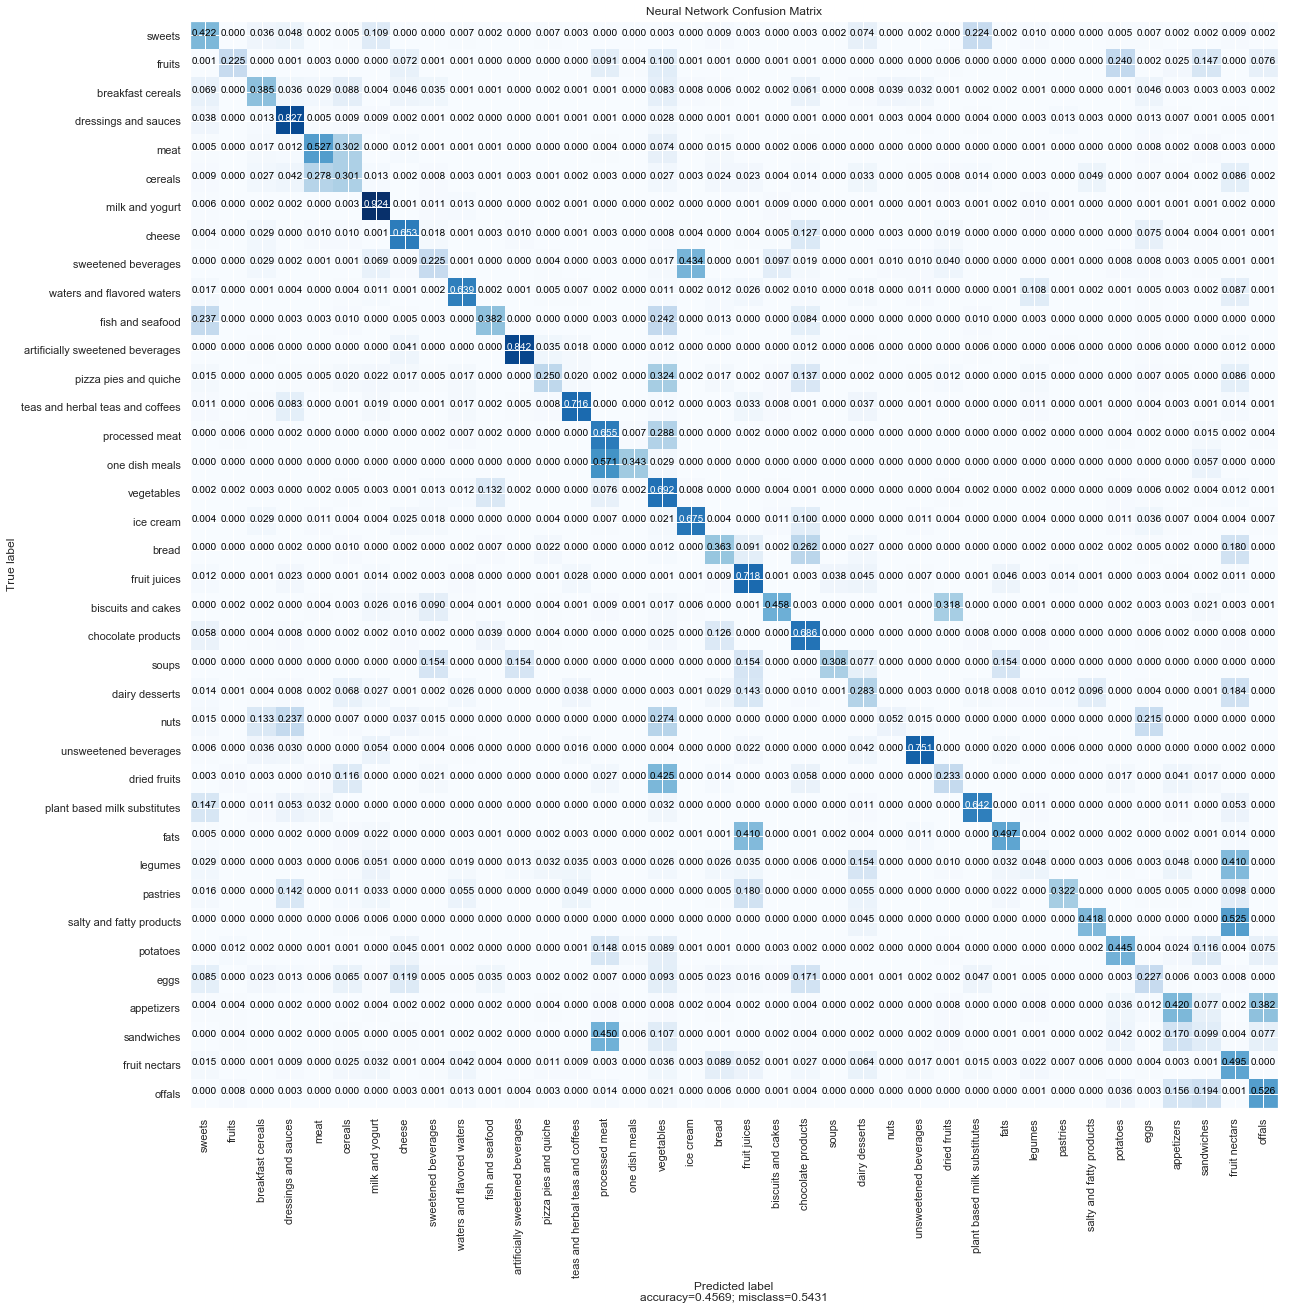

In [354]:
plot_confusion_matrix(cm=metrics.confusion_matrix(df_neural['pnns_groups_2'], df_neural['robotoff_pnns']), target_names=df.pnns_groups_2.unique(), figsize=(20,20), cmap='Blues', title='Neural Network Confusion Matrix')

### We can then get scoring metrics only for predictions that have a high confidence, e.g. > 0.85

In [355]:
#Loc predictions with more than 0.85 confidence level
high_conf = df.loc[df['robotoff_data.confidence'] > 0.85]
high_conf_report = get_classification_report(high_conf.pnns_groups_2, high_conf.robotoff_pnns, model='neural', sortby='f1-score')
#Display labels with a f1-score > 0.75
high_conf_report.loc[high_conf_report['neural_f1-score'] > 0.75]

neural_precision  neural_recall  neural_f1-score  \
cheese                            0.87           0.95             0.91   
eggs                              0.86           0.94             0.90   
dressings and sauces              0.88           0.78             0.83   
fish and seafood                  0.78           0.84             0.81   
bread                             0.72           0.90             0.80   

                      neural_support  
cheese                        1176.0  
eggs                            65.0  
dressings and sauces          1221.0  
fish and seafood               263.0  
bread                          555.0

In [363]:
high_conf_report.loc[high_conf_report['neural_f1-score'] > 0.75][['neural_recall', 'neural_precision', 'neural_f1-score']].plot(kind='bar', cmap='Dark2')